In [38]:
import sys
sys.path.append(r"I:/1-ML/Base")
print(sys.path)
import os
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from utils.PDE_Net import DeepONet_NS, weight_init
from argparse import Namespace
from utils.utilities3 import *
import time

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

['i:\\1-ML\\工况合集\\5训练集-0.5m窗口-split2（base）\\DON', 'h:\\Anaconda\\envs\\my_torch\\python310.zip', 'h:\\Anaconda\\envs\\my_torch\\DLLs', 'h:\\Anaconda\\envs\\my_torch\\lib', 'h:\\Anaconda\\envs\\my_torch', '', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages\\win32', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages\\win32\\lib', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages\\Pythonwin', 'I:/ML/工况合集', 'I:/ML/工况合集', 'I:/1-ML/工况合集', 'I:/1-ML/工况合集']


In [39]:
dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
self_split = 2

config = Namespace(
	project_name='DON',

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),

	dx=dx,
	n_x=n_x,
	n_y=n_y,
	p_x=p_x,
	p_y=p_y,
	self_split=2,

	epochs=2000,
	batch_size=6000,
	learning_rate=0.0007565,
	dropout=0.4,
	weight_decay=0.00042,
	max_norm=2.864,

	branch_input=204,
	trunk_input=2,
	hidden_size=512,
	branch_layer=6,
	trunk_layer=4,
	activation='LeakyReLU',
	
	optim_type='AdamW',

	path_trained_model=r'trained_model',
	path_label=r'../train_data/label',
	path_label_test=r'../test_data/label',
)

In [40]:
activation = torch.nn.__dict__[config.activation]()
model = DeepONet_NS(config.branch_input, config.trunk_input, config.branch_layer, config.trunk_layer, config.hidden_size, activation, config.dropout)
model.to(device)
model.eval()

optimizer = torch.optim.__dict__[config.optim_type](params=model.parameters(), lr=config.learning_rate)
myloss = nn.MSELoss()

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True, min_lr=1e-6)

begin_epoch = 0
batch_size = 300


I:\1-ML/工况合集\utils\PDE_Net.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_last = torch.tensor(torch.zeros(1), requires_grad=True, device=device)


In [66]:
path_trained_model = r'trained_model'

file_list = os.listdir(path_trained_model)
if len(file_list) > 0:
	last_model = os.listdir(path_trained_model)[-1]
load_path = os.path.join(path_trained_model, last_model)
# load_path = r'I:\ML\Package_model\DeepONet\original_model\trained_model\original_DON_48000_4000.pth'
print('load_path:', load_path)
begin_epoch = load_model(load_path, optimizer, model)
model.to(device)

model.eval()

test_label = np.load(r'I:\1-ML\工况合集\data\original_labels_data\6.npy')
# test_data = np.load(r'train_data/train_data_velocity.npy')
# train_data = np.concatenate((train_data,test_data),axis=0)
print(test_label.shape)
# print(test_data.shape)

test_bc = np.concatenate((test_label[:,:,0,0], test_label[:,-1,:,0], test_label[:,:,-1,0], test_label[:,0,:,0]), axis=1)
# test_bc = np.concatenate((test_data[:,:,0,0], test_data[:,-1,:,0], test_data[:,:,-1,0], test_data[:,0,:,0]), axis=1)
print(test_bc.shape)
# print(test_bc.shape)

test_label = test_label.reshape(test_label.shape[0],-1)
print(test_label.shape)
test_label = torch.Tensor(test_label)
test_bc = torch.Tensor(test_bc)
# test_data = torch.Tensor(test_data)
# test_bc = torch.Tensor(test_bc)

load_path: trained_model\DON_5dataset_0.5m_split4_10000.pth
Load model at epoch: 10000
(96, 51, 51, 1)
(96, 204)
(96, 2601)


In [67]:
# x_normalizer = GaussianNormalizer(test_bc)
# x_data = x_normalizer.encode(test_bc)
# y_normalizer = GaussianNormalizer(test_label)
# y_data = y_normalizer.encode(test_label)

x_test,y_test,x_min_test,x_max_test = normalize(test_bc, test_label)

In [68]:
coordinate = np.meshgrid(np.linspace(0,dx,p_x), np.linspace(0,dx,p_y))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)

x_test = x_test.to(device)
y_test = y_test.to(device)

coordinate = torch.Tensor(coordinate).to(device)


In [69]:
start_time = time.time()
model.eval()

with torch.no_grad():

	x_test = x_test.float().to(device)			# [length,time_step,51,51,3]
	y_test = y_test.float().to(device)			# [length,time_step,51,51,3]
	x_min_test = x_min_test.float().to(device)
	x_max_test = x_max_test.float().to(device)

	pred_test = model(x_test, coordinate)

	pred_test = inverse_normalize(pred_test,x_min_test,x_max_test)
	y_test = inverse_normalize(y_test,x_min_test,x_max_test)

	loss_test = myloss(pred_test.clone(), y_test.clone())
	end_time = time.time()
	print('loss_test:', loss_test)

print('time cost:', end_time-start_time)

loss_test: tensor(0.0029, device='cuda:0')
time cost: 0.00724029541015625


little contour plot

(51, 51)


[]

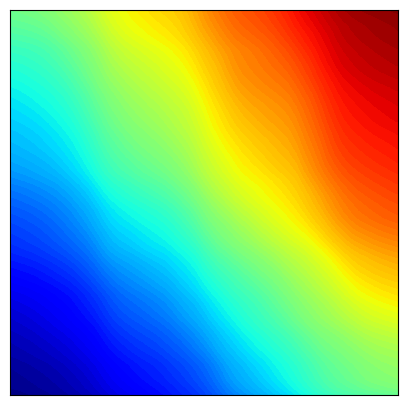

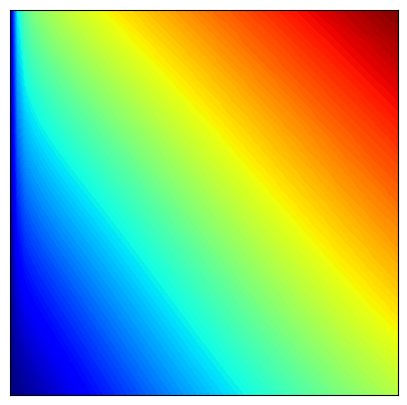

In [29]:
index = 1
x = pred_test.cpu().detach().numpy()[index].reshape(p_x,p_y)
y = y_test.cpu().detach().numpy()[index].reshape(p_x,p_y)
xx = coordinate.cpu().detach().numpy()[:,0].reshape(p_x,p_y)
yy = coordinate.cpu().detach().numpy()[:,1].reshape(p_x,p_y)
print(xx.shape)
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.contourf(xx,yy,x,100,cmap='jet')
x1_min, x1_max = axs.get_xlim()
y1_min, y1_max = axs.get_ylim()
axs.set_xticks([])
axs.set_yticks([])
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.contourf(xx,yy,y,100,cmap='jet')
axs.set_xlim(x1_min, x1_max)
axs.set_ylim(y1_min, y1_max)
axs.set_xticks([])
axs.set_yticks([])

all zone plot

(96, 51, 51, 1)


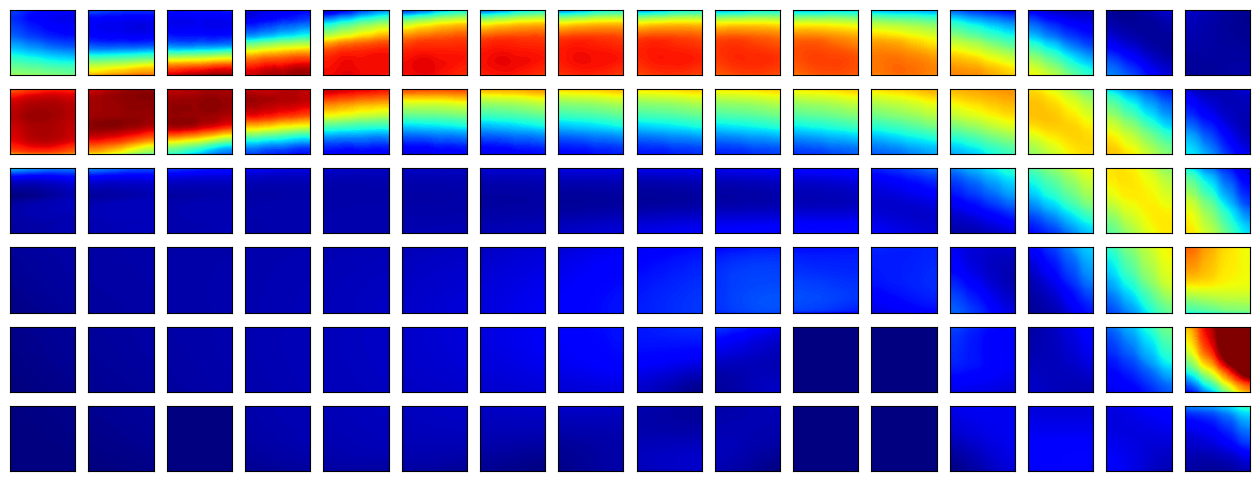

In [70]:
pred_test = pred_test.reshape(-1,p_x,p_y,1)
test_x = pred_test.cpu().detach().numpy()
# test_x[42, :, :, :] = 0
# test_x[43, :, :, :] = 0
# test_x[48, :, :, :] = 0
# test_x[49, :, :, :] = 0
test_x[9, :, 51:, :] = 0
test_x[12, :, :51, :] = 0
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(16,6))
print(test_x.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[n_y-1-i,j].contourf(coordinate[0], coordinate[1], test_x[i+j*n_y,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[n_y-1-i,j].set_aspect('equal')
		axs[n_y-1-i,j].set_xticks([])
		axs[n_y-1-i,j].set_yticks([])


plt.show()

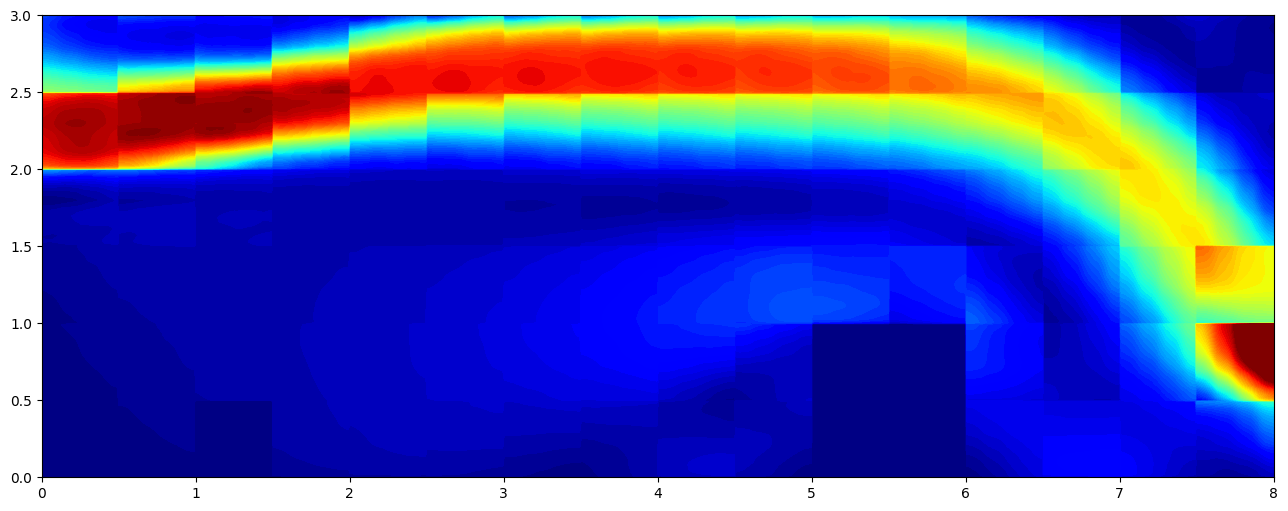

In [71]:
all_zone = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == (n_y-1) and j != (n_x-1):
			all_zone[-p_x:,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*n_y,:,:,0]
		elif i != (n_y-1) and j == (n_x-1):
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,-p_y:] = test_x[i+j*n_y,:,:,0]
		elif i == (n_y-1) and j == (n_x-1):
			all_zone[-p_x:,-p_y:] = test_x[i+j*n_y,:,:,0]
		else:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*n_y,:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

[]

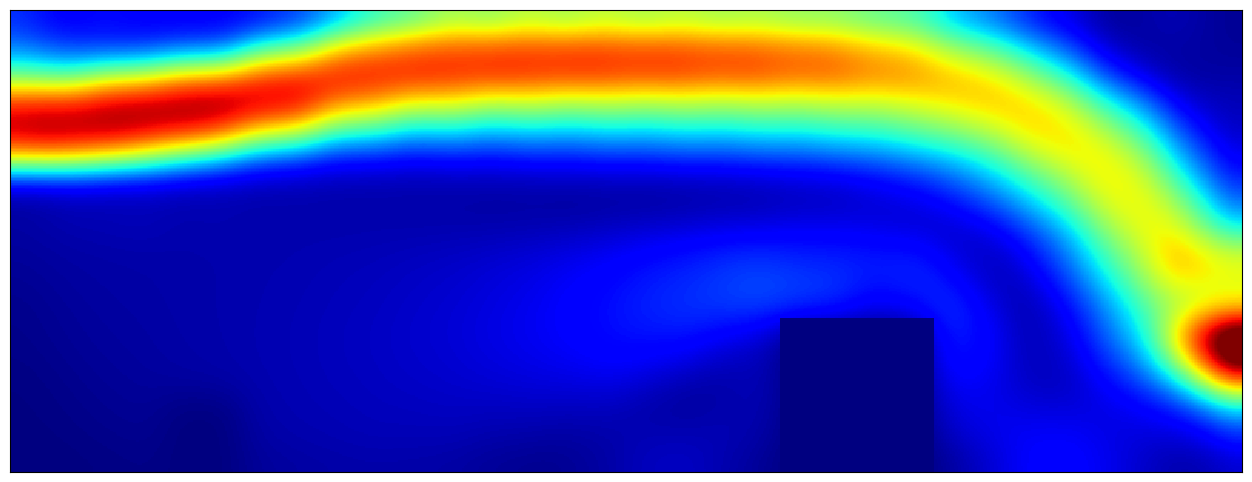

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d, convolve2d, savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2


data = all_zone 

sigma = 12  
smoothed_data = gaussian_filter(data, sigma=sigma)

xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)
smoothed_data[:100, 500:600] = 0
fig,axs = plt.subplots(1,figsize=(16,6))
contour = axs.pcolor(xnew,ynew,smoothed_data,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# cbar = plt.colorbar(contour)

truth data plot

In [73]:
truth_data = np.load(r'I:\1-ML\工况合集\data\original_labels_data\6.npy')
print(truth_data.shape)

(96, 51, 51, 1)


(96, 51, 51, 1)


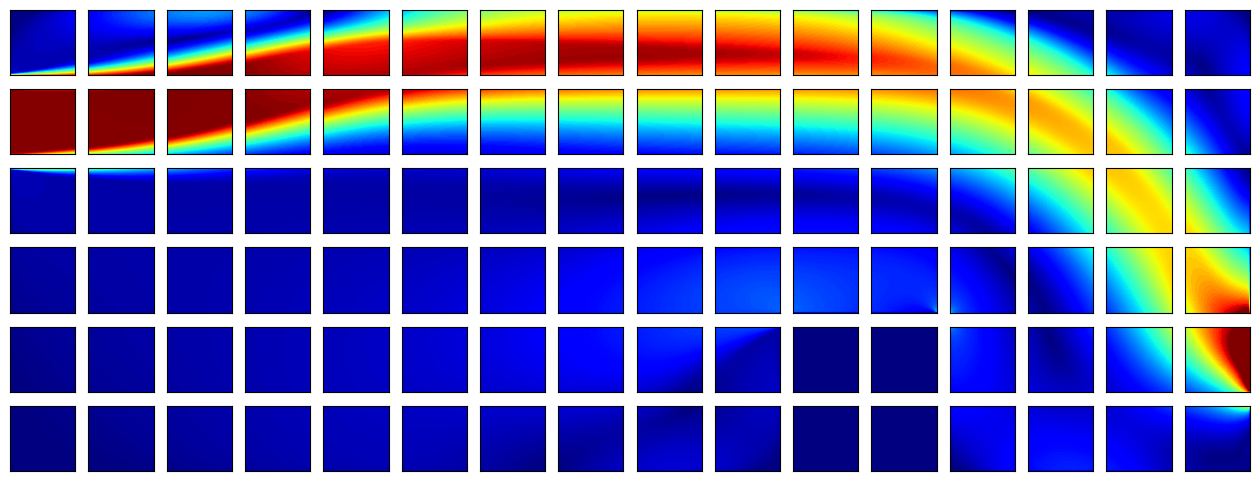

In [74]:
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(n_x,n_y))
print(truth_data.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], truth_data[i+j*(n_y),:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

[]

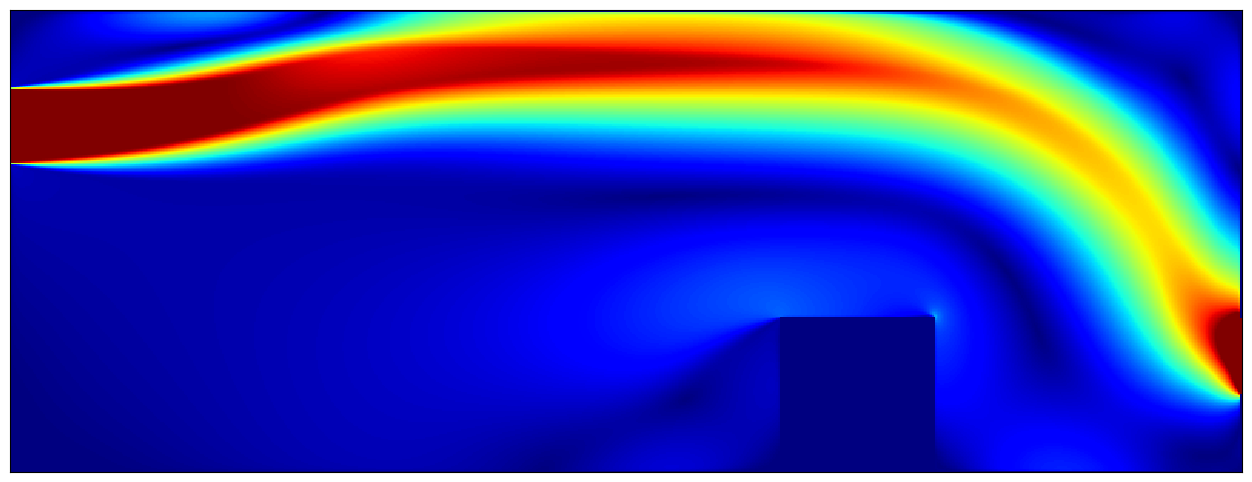

In [75]:
all_zone_truth = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == (n_y-1) and j != (n_x-1):
			all_zone_truth[-p_x:,j*(p_y-1):(j+1)*(p_y-1)+1] = truth_data[i+j*n_y,:,:,0]
		elif i != (n_y-1) and j == (n_x-1):
			all_zone_truth[i*(p_x-1):(i+1)*(p_x-1)+1,-p_y:] = truth_data[i+j*n_y,:,:,0]
		elif i == (n_y-1) and j == (n_x-1):
			all_zone_truth[-p_x:,-p_y:] = truth_data[i+j*n_y,:,:,0]
		else:
			all_zone_truth[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = truth_data[i+j*n_y,:,:,0]

fig,axs = plt.subplots(1,figsize=(16,6))
contour = axs.pcolor(xnew,ynew,all_zone_truth,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])

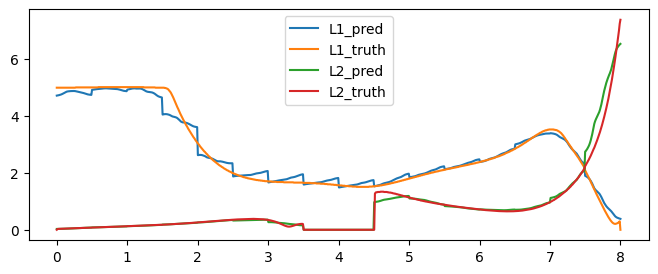

In [44]:
x1_test = all_zone[:,500]
x1_truth = all_zone_truth[:,500]
y1_test = all_zone[225,:]
y1_truth = all_zone_truth[225,:]
y2_test = all_zone[75,:]
y2_truth = all_zone_truth[75,:]
plt.figure(figsize=(8,3))
l1, = plt.plot(np.linspace(0,8,800),y1_test,label='L1_pred')
l2, = plt.plot(np.linspace(0,8,800),y1_truth,label='L1_truth')
L3, = plt.plot(np.linspace(0,8,800),y2_test,label='L2_pred')
L4, = plt.plot(np.linspace(0,8,800),y2_truth,label='L2_truth')
plt.legend(handles=[l1, l2, L3, L4], labels=['L1_pred', 'L1_truth', 'L2_pred', 'L2_truth'], loc='best')


[]

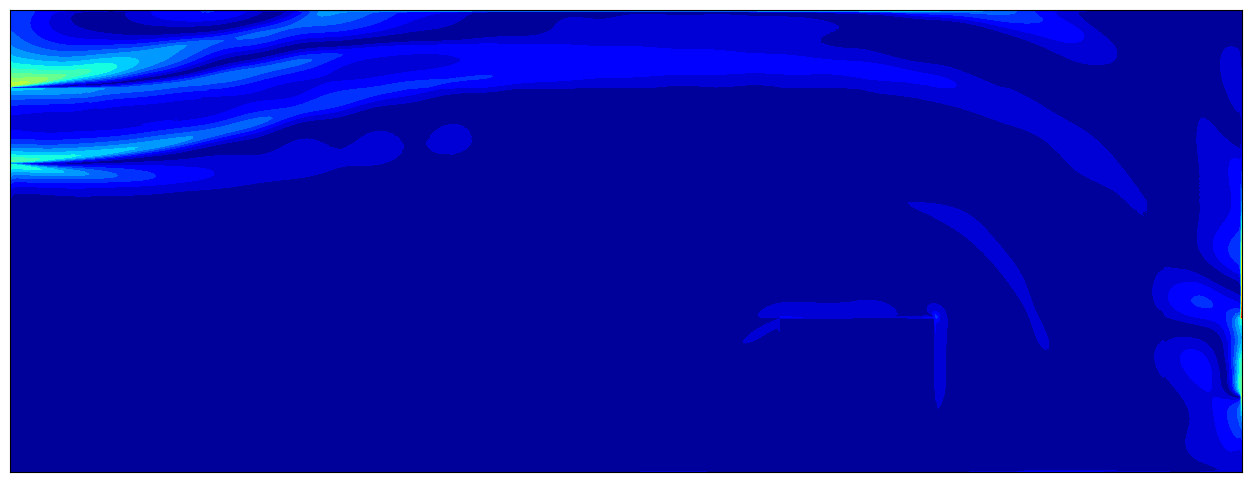

In [76]:
error = np.abs(all_zone_truth-smoothed_data)
fig,axs = plt.subplots(1,figsize=(16,6))
coontour = axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),error,20,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# colorbar = fig.colorbar(coontour)

In [81]:
import numpy as np


data = np.array([1, 2, 3, 4, 5])

sample_std_dev = np.std(smoothed_data, ddof=1)

standard_error = sample_std_dev / np.sqrt(len(data))



标准误差: 0.11899564577394699
